In [1]:
import seaborn as sns
import matplotlib 

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates

import math
from sys import path
path.append('..//modules')
path.append('..//dumps//reg_dmo_pdf')
import time
import pandas as pd
import psycopg2 as pg
from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import create_engine, MetaData, Table
import pandas.io.sql as psql

#create a postgres engine and a pg connection
from modules.db_connector import *
print("DB connecting engine imported")


#print(matplotlib.rcParams.keys())

font = {'family' : 'Roboto', 
        'weight': '300',
        'size'   : 30}


axesfoo = {'labelweight': '300'}
#unified_colors
clr_mean = "red"
clr_mode = "black"
clr_median = "orange"

import matplotlib 
matplotlib.rc('font', **font)
matplotlib.rc('axes', **axesfoo)

#https://medium.com/dunder-data/automatically-wrap-graph-labels-in-matplotlib-and-seaborn-a48740bc9ce
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

    


DB connecting engine imported


In [2]:
with engine.connect() as con1:
    q = """
  select *, to_date(visit_month || '-' ||visit_year, 'Mon-Year') dd,
    case 
        when visit_month in ('Dec', 'Jan', 'Feb') THEN 'Winter'
        when visit_month in ('Mar', 'Apr', 'May') THEN 'Spring'
        when visit_month in ('Jun', 'Jul', 'Aug') THEN 'Summer'
        when visit_month in ('Sep', 'Oct', 'Nov') THEN 'Fall'
        else null end season,
    case 
        when visit_month in ('Jan', 'Feb', 'Mar') THEN 1
        when visit_month in ('Apr', 'May', 'Jun') THEN 2
        when visit_month in ('Jul', 'Aug', 'Sep') THEN 3
        when visit_month in ('Oct', 'Nov', 'Dec') THEN 4
        else null end qrt
        from gtlab.sk_ta_geosites_reviews 
        
        
left join
(select id poi_id, poi_name, CASE WHEN dmo_id is null then 'NO DMO'::text else 'DMO ' || dmo_id end nm_dmoid from gtlab.sk_pois_activities_tripadvisor_0723_details) dmos
using (poi_id)
left join
(select id poi_id, trp_3_subclass, trp_4_groups from gtlab.sk_ta_trp_cat_test) trps
using (poi_id)
where visit_month <> 'n/a'
order by dd
    """
    

   
    df_revs = pd.read_sql(q, con=con1)

    con1.close()

In [3]:
n_wo_m = df_revs.query('visit_month == "n/a"')['review_en'].count()
n_w_m = df_revs.query('visit_month != "n/a"')['review_en'].count()
n_wo_y = df_revs.query('visit_year == "n/a"')['review_en'].count()
n_w_y = df_revs.query('visit_year != "n/a"')['review_en'].count()

print(n_w_m, n_wo_m)
print(n_w_y, n_wo_y)

2463 0
2463 0


In [3]:
df_caves = df_revs.query('trp_4_groups == "Caves"')
n_reviews = len(df_revs.index)
n_caves = len(df_caves['poi_id'].unique())
n_rev_caves = df_caves['poi_id'].count()
n_rev_caves/n_reviews

df_caves['Date'] = pd.to_datetime(df_revs['dd'], format='%Y-%m-%d')
df_caves['year'] = pd.DatetimeIndex(df_caves['Date']).year
df_caves['month'] = pd.DatetimeIndex(df_caves['Date']).month



dfg1 = pd.pivot_table(df_caves, index=['Date', 'year', 'month'], values=['sent1_review_polarity', 'sent2_review_compound'], aggfunc='count')
dfg1 = dfg1.reset_index()
dfg1 =dfg1.sort_values(by=['Date'])


dfg2 = pd.pivot_table(df_caves, index=['Date', 'year', 'month'], values=['sent2_review_compound', 'sent1_review_polarity'], aggfunc='median')
dfg2 = dfg2.reset_index()
dfg2 =dfg2.sort_values(by=['Date'])




C:\Users\csb\AppData\Local\Temp\ipykernel_9312\1975569907.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_caves['Date'] = pd.to_datetime(df_revs['dd'], format='%Y-%m-%d')
C:\Users\csb\AppData\Local\Temp\ipykernel_9312\1975569907.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_caves['year'] = pd.DatetimeIndex(df_caves['Date']).year
C:\Users\csb\AppData\Local\Temp\ipykernel_9312\1975569907.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [4]:
import numpy as np
from scipy.stats import variation
df_m_sent_variablity = dfg2[['year', 'month', 'sent1_review_polarity', 'sent2_review_compound']]
df_m_sent_variablity

for i in range (2010, 2025):
    blob_var = variation(df_m_sent_variablity.query('year == @i')['sent1_review_polarity'])
    vader_var = variation(df_m_sent_variablity.query('year == @i')['sent2_review_compound'])
    print(i, blob_var, vader_var, vader_var > blob_var)
    
    



2010 0.0 0.0 False
2011 0.19815668202765108 0.020438341695273282 False
2012 0.5262167840862042 0.1901263151120884 False
2013 0.29717168413285383 0.2138909296722176 False
2014 0.73804359323824 0.19077540129018514 False
2015 0.2737794112948374 0.06756129362512965 False
2016 0.27836936968160886 0.06749326824727644 False
2017 0.26393885333296574 0.07654133099120594 False
2018 0.2832173707671445 0.18018945047218726 False
2019 0.5469253196067894 0.23620062425964747 False
2020 0.2581428423397372 0.1270459187085005 False
2021 0.37028991472540024 0.9641498191628092 True
2022 0.7963879780750179 0.2717430519656884 False
2023 0.8892308227141579 2.128944806680762 True
2024 0.0 0.0 False


C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

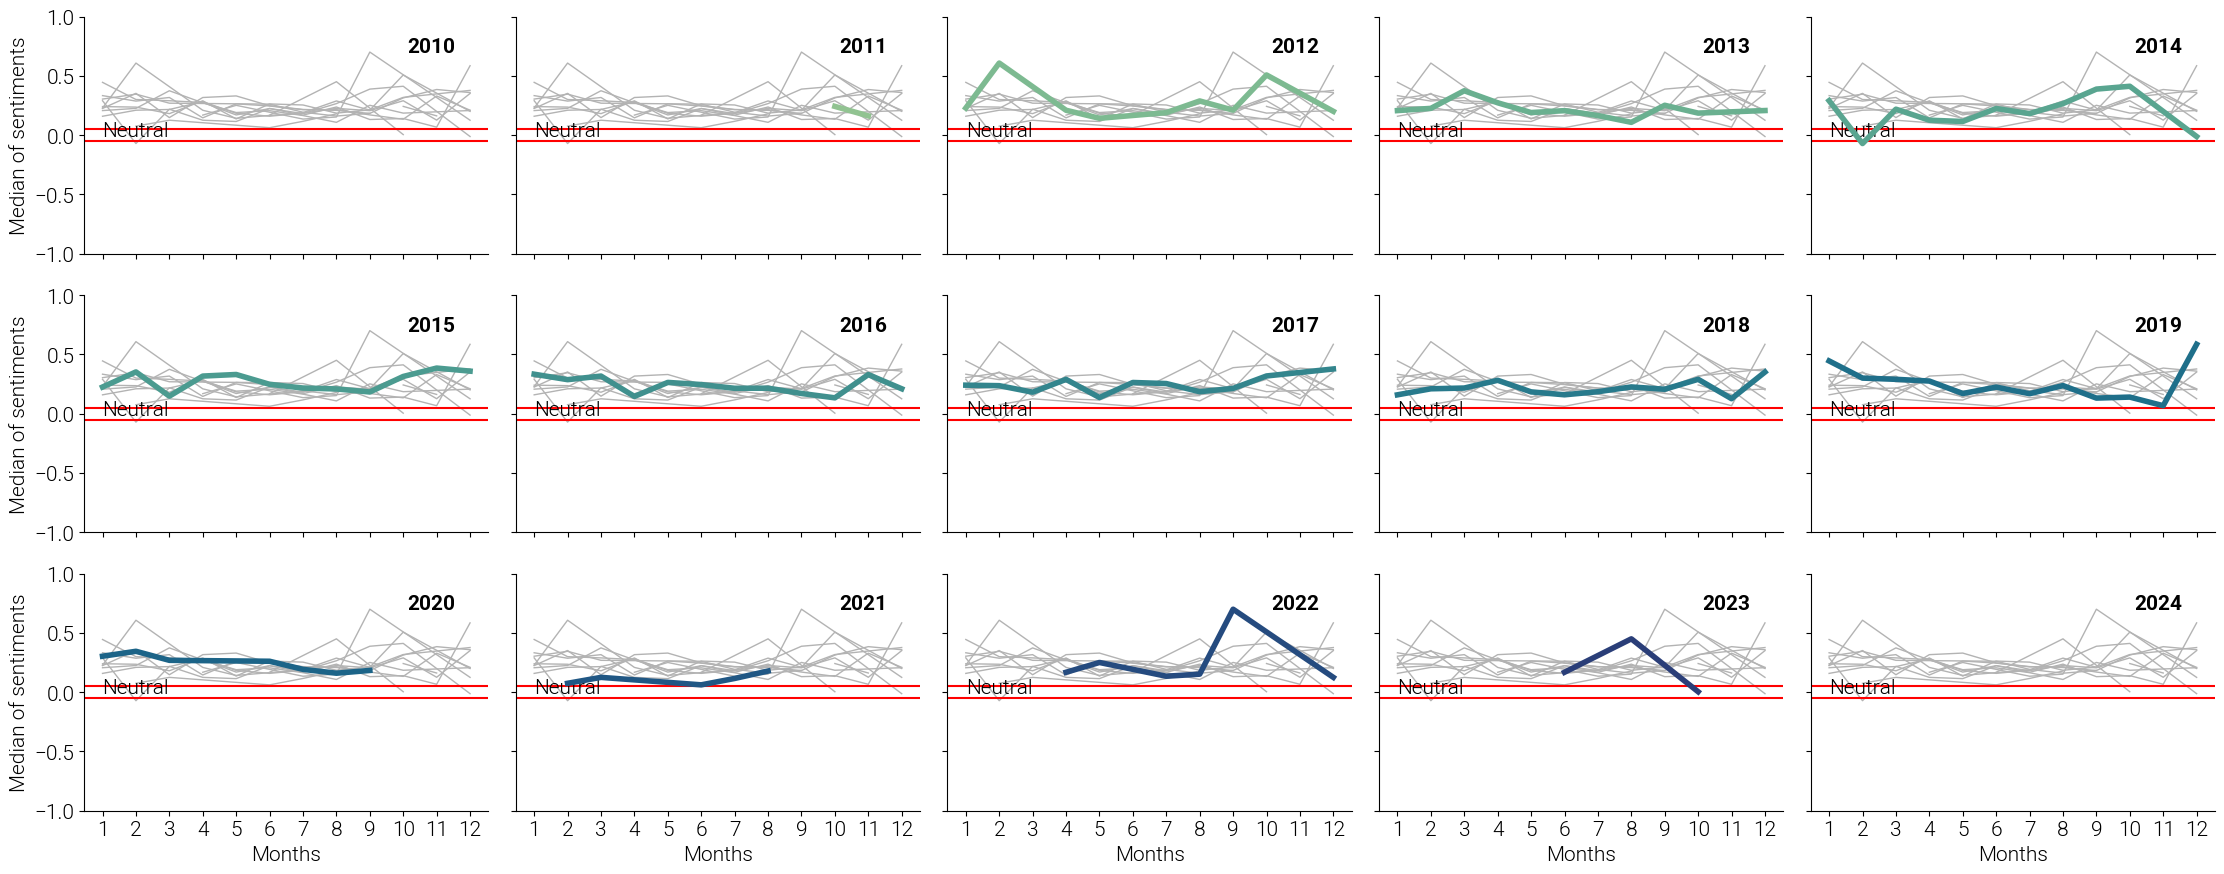

In [140]:
# Plot each year's time series in its own facet
g = sns.relplot(
    data=dfg2,
    x="month", y="sent1_review_polarity", col="year", hue="year",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=5, height=3, aspect=1.5, legend=False,
)

# Iterate over each subplot to customize further
for year, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .85, year, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=dfg2, x="month", y="sent1_review_polarity", units="year",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )
    ax.axhline(0.05, label="Neutral", color='red')
    ax.axhline(-0.05, label="Neutral", color='red')
    ax.annotate("Neutral", xy=(1,-0.01), )


# Reduce the frequency of the x axis ticks
#ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax.set_yticks([-1, -.5, 0, .5, 1])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("Months", "Median of sentiments")
g.tight_layout()



#fig = g.get_figure()
g.savefig("dumps/exported_figs/caves_sent_monthl_textblob.svg", bbox_inches="tight")

C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

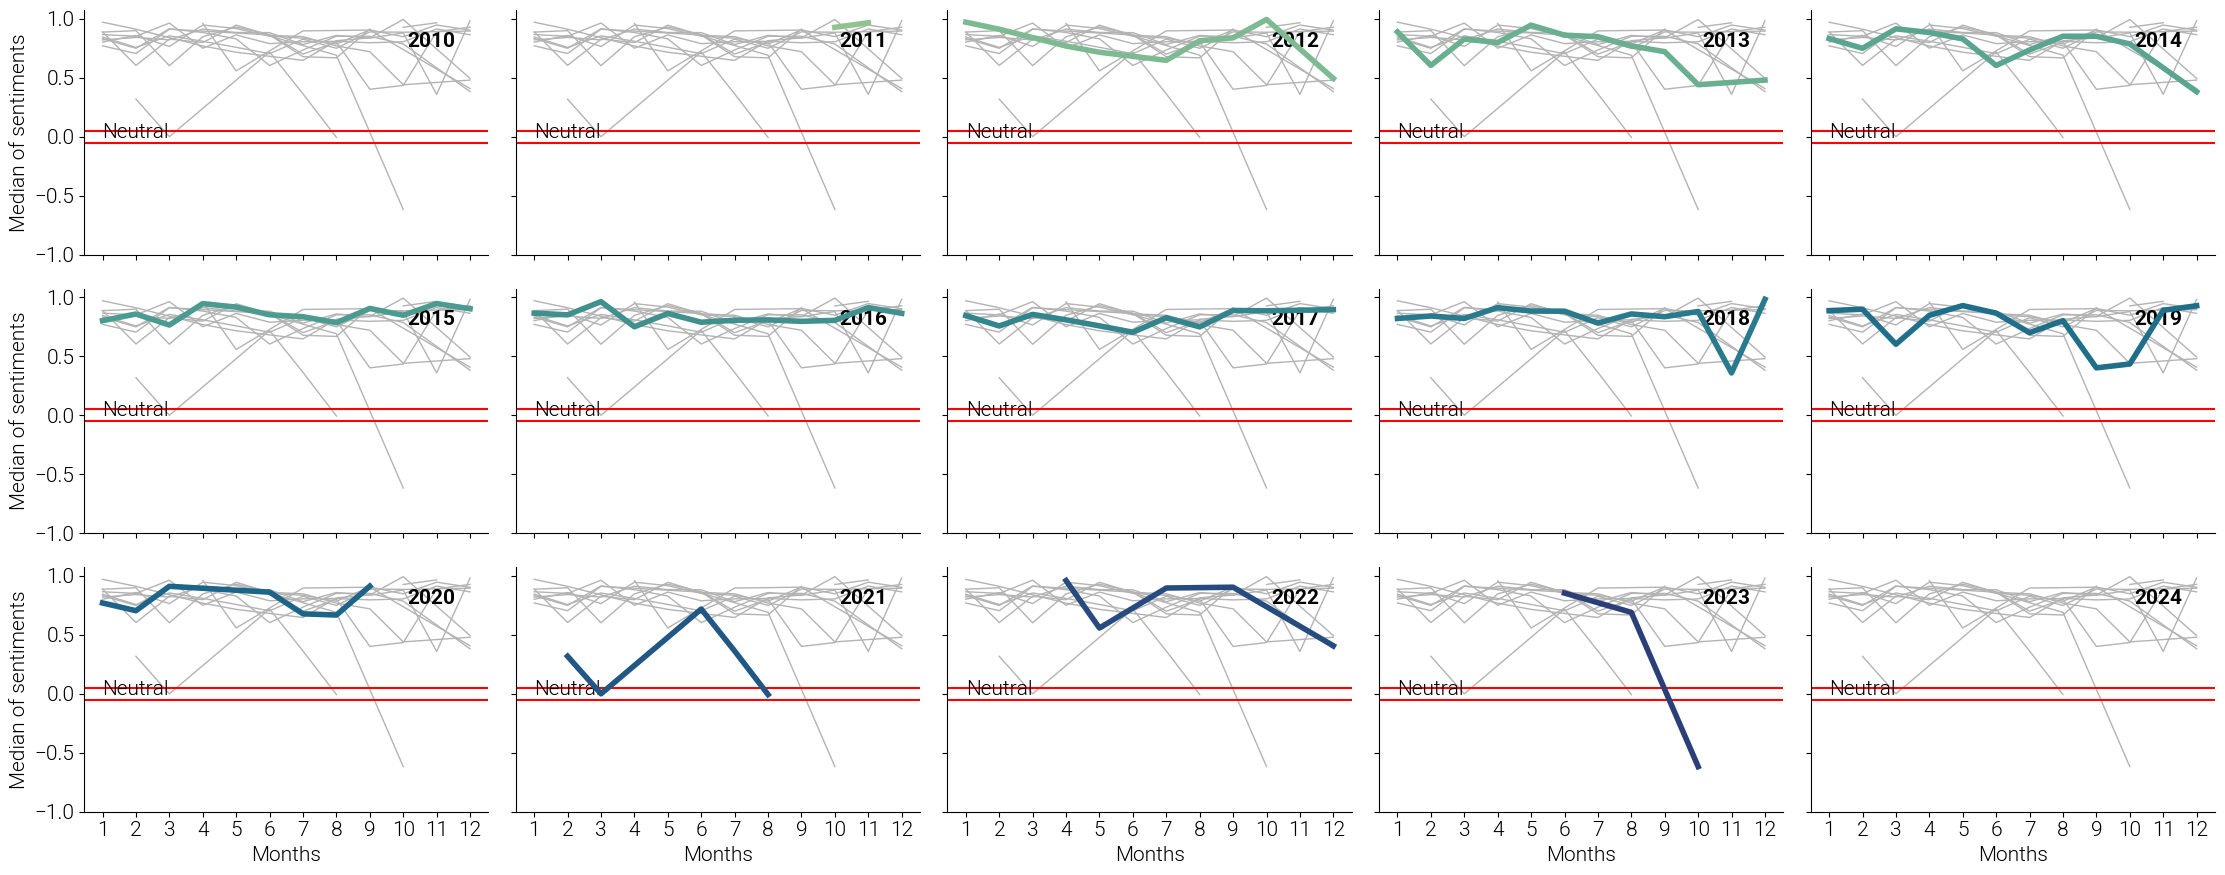

In [139]:
# Plot each year's time series in its own facet
g = sns.relplot(
    data=dfg2,
    x="month", y="sent2_review_compound", col="year", hue="year",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=5, height=3, aspect=1.5, legend=False,
)

# Iterate over each subplot to customize further
for year, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .85, year, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=dfg2, x="month", y="sent2_review_compound", units="year",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )
    ax.axhline(0.05, label="Neutral", color='red')
    ax.axhline(-0.05, label="Neutral", color='red')
    ax.annotate("Neutral", xy=(1,-0.01), )


# Reduce the frequency of the x axis ticks
#ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax.set_yticks([-1, -.5, 0, .5, 1])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("Months", "Median of sentiments")
g.tight_layout()



#fig = g.get_figure()
g.savefig("dumps/exported_figs/caves_sent_monthl_vader.svg", bbox_inches="tight")

C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


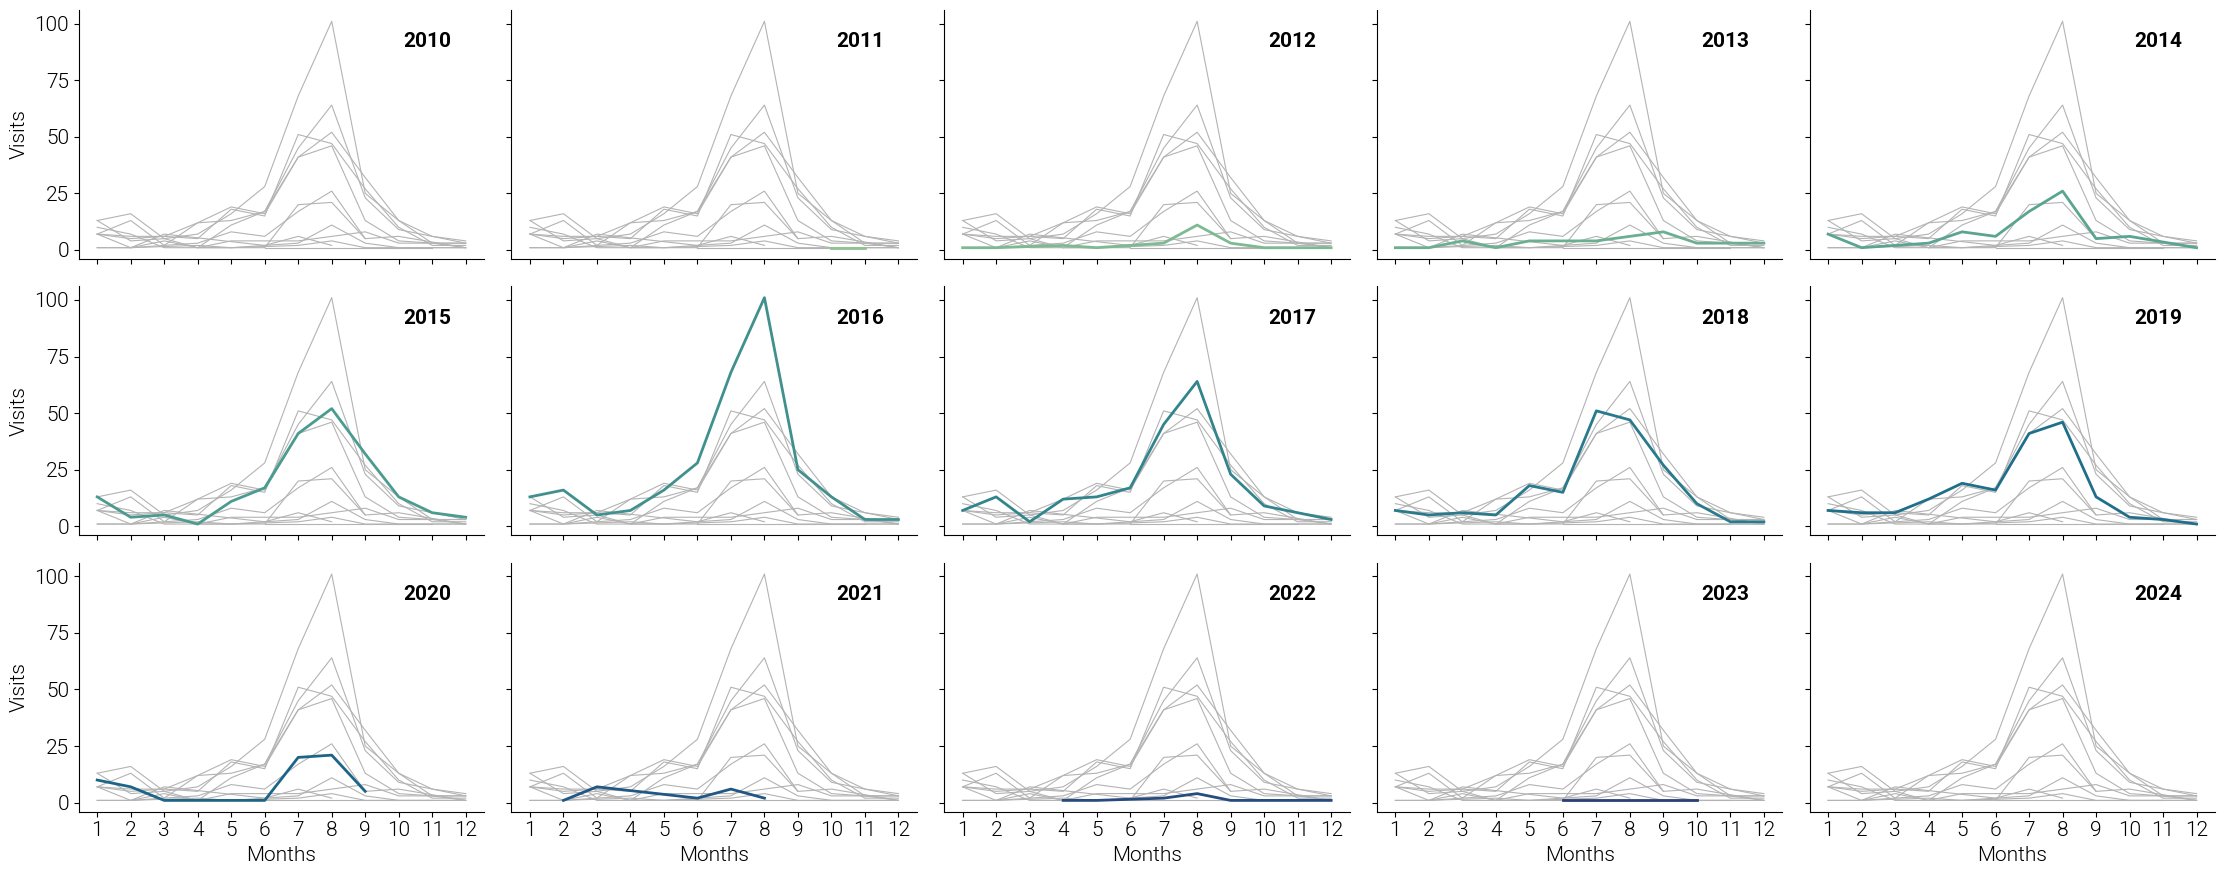

In [132]:

# Plot each year's time series in its own facet
g = sns.relplot(
    data=dfg1,
    x="month", y="sent1_review_polarity", col="year", hue="year",
    kind="line", palette="crest", linewidth=2, zorder=5, markers=True,
    col_wrap=5, height=3, aspect=1.5, legend=False,
)

# Iterate over each subplot to customize further
for year, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .85, year, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=dfg1, x="month", y="sent1_review_polarity", units="year",
        estimator=None, color=".7", linewidth=0.8, markers=True, ax=ax
    )

# Reduce the frequency of the x axis ticks
#ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("Months", "Visits")
g.tight_layout()


#fig = g.get_figure()
g.savefig("dumps/exported_figs/caves_visit_monthl.svg", bbox_inches="tight")





In [38]:
df_avg_title = pd.pivot_table(df_revs, index=['Date'], values=['sent1_title_polarity', 'sent2_title_compound', 'sent3_title_compound', 'sent4_title_polarity'], aggfunc='mean')
df_avg_title = df_avg_title.reset_index()
df_n_title = pd.pivot_table(df_revs, index=['Date'], values=['review_en'], aggfunc='count')
df_n_title = df_n_title.reset_index()
dfg3 = pd.merge(df_n_title, df_avg_title, on = 'Date', how='outer')


C:\Users\csb\AppData\Local\Temp\ipykernel_18604\3612949579.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfrv.loc[:, 'part'] =  'Review'
C:\Users\csb\AppData\Local\Temp\ipykernel_18604\3612949579.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfrv['sent1'] =  [x for x in dfrv['sent1_review_polarity']]
C:\Users\csb\AppData\Local\Temp\ipykernel_18604\3612949579.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

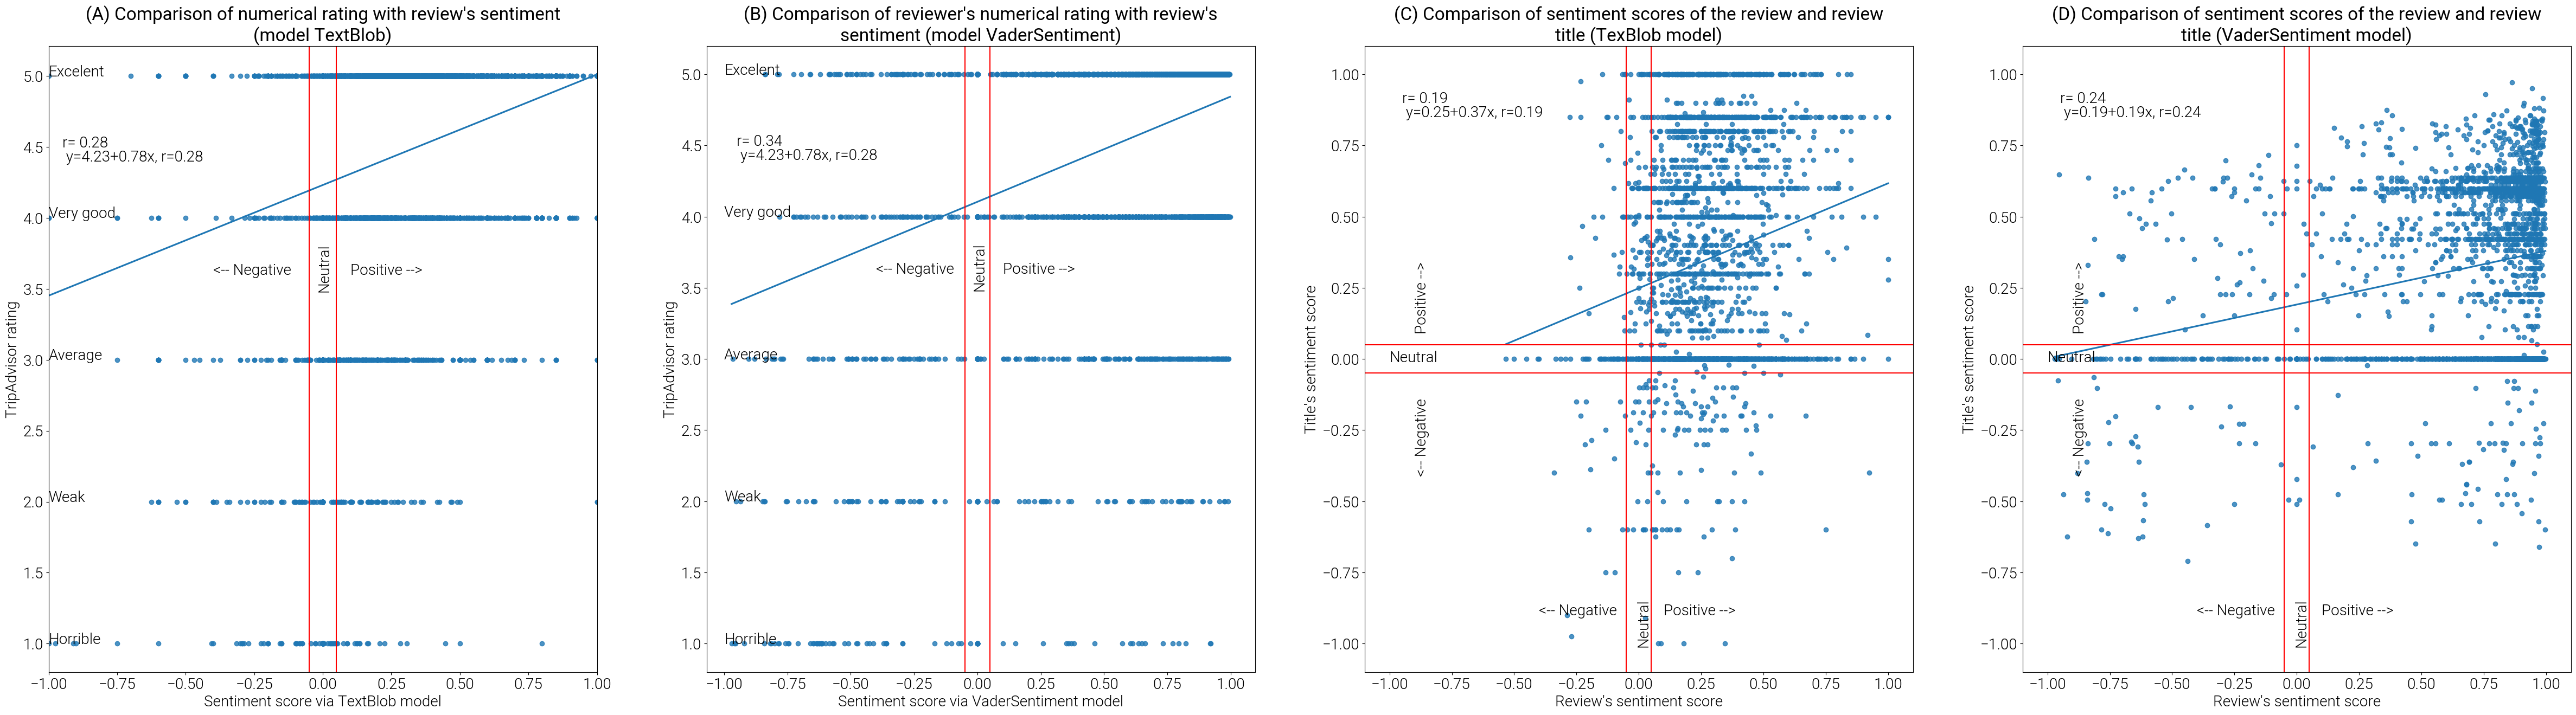

In [116]:
fig = plt.figure(figsize=(60, 15))
gs = GridSpec(1, 4, figure=fig)


ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])


#, hue=None, size=None, style=None, palette=None, hue_order=None, hue_norm=None, sizes=None, size_order=None, size_norm=None, markers=True, style_order=None, legend='auto', ax=None, **kwargs
df_revs['review_rating'] = [float(x)  for x in df_revs['review_rating']] 
dfrv = df_revs[['review_en', 'review_rating', 'sent1_review_polarity', 'sent2_review_compound']]
dfrv.loc[:, 'part'] =  'Review'
dfrv['sent1'] =  [x for x in dfrv['sent1_review_polarity']]
dfrv['sent2'] =  [x for x in dfrv['sent2_review_compound']]
dfrv = dfrv.drop(columns=['sent1_review_polarity', 'sent2_review_compound'])

dftt = df_revs[['review_en', 'review_rating', 'sent1_title_polarity', 'sent2_title_compound']]
dftt.loc[:, 'part'] =  'Title'
dftt['sent1'] =  [x for x in dftt['sent1_title_polarity']]
dftt['sent2'] =  [x for x in dftt['sent2_title_compound']]
dftt = dftt.drop(columns=['sent1_title_polarity', 'sent2_title_compound'])
df_scat = pd.concat([dfrv, dftt])
df_scat = df_scat.sort_values(by=['review_rating'], ascending=False)



g1 = sns.regplot(data=df_scat,  x='sent1', y='review_rating', ci=None, ax=ax1)
g1.set_xlim(left=-1, right=1)
ax1.axvline(0.05, label="Neutral", color='red')
ax1.axvline(-0.05, label="Neutral", color='red')
ax1.annotate("Neutral", xy=(-0.02,3.5), rotation=90)
ax1.annotate("Positive -->", xy=(0.1,3.6))
ax1.annotate("<-- Negative", xy=(-0.4,3.6))
ax1.annotate("Horrible", xy=(-1,1))
ax1.annotate("Weak", xy=(-1,2))
ax1.annotate("Average", xy=(-1,3))
ax1.annotate("Very good", xy=(-1,4))
ax1.annotate("Excelent", xy=(-1,5))
ax1.set(xlabel="\n".join(textwrap.wrap('Sentiment score via TextBlob model',60)), ylabel='TripAdvisor rating')
ax1.set(title="\n".join(textwrap.wrap("(A) Comparison of numerical rating with review's sentiment (model TextBlob)",60)))


g2 = sns.regplot(data=df_scat,  x='sent2', y='review_rating', ci=None, ax=ax2)
ax2.axvline(0.05, label="Neutral", color='red')
ax2.axvline(-0.05, label="Neutral", color='red')
ax2.annotate("Neutral", xy=(-0.02,3.5), rotation=90)
ax2.annotate("Positive -->", xy=(0.1,3.6))
ax2.annotate("<-- Negative", xy=(-0.4,3.6))
ax2.annotate("Horrible", xy=(-1,1))
ax2.annotate("Weak", xy=(-1,2))
ax2.annotate("Average", xy=(-1,3))
ax2.annotate("Very good", xy=(-1,4))
ax2.annotate("Excelent", xy=(-1,5))
ax2.set(xlabel="\n".join(textwrap.wrap('Sentiment score via VaderSentiment model',60)), ylabel='TripAdvisor rating')
ax2.set(title="\n".join(textwrap.wrap("(B) Comparison of reviewer's numerical rating with review's sentiment (model VaderSentiment)",60)))

g3 = sns.regplot(data=df_revs,  x='sent1_review_polarity', y='sent1_title_polarity',  ci=None, ax=ax3)
g3.set_xlim([-1.1, 1.1])
g3.set_ylim([-1.1, 1.1])
ax3.axvline(0.05, label="Neutral", color='red')
ax3.axvline(-0.05, label="Neutral", color='red')
ax3.axhline(0.05, label="Neutral", color='red')
ax3.axhline(-0.05, label="Neutral", color='red')
ax3.annotate("Neutral", xy=(-0.01 ,-1), rotation=90)
ax3.annotate("Neutral", xy=(-1,-0.01), )
ax3.annotate("Positive -->", xy=(0.1,-0.9))
ax3.annotate("Positive -->", xy=(-0.9,0.1), rotation=90)
ax3.annotate("<-- Negative", xy=(-0.4,-0.9))
ax3.annotate("<-- Negative", xy=(-0.9,-0.4), rotation=90)
ax3.set(xlabel="\n".join(textwrap.wrap('Review\'s sentiment score',60)), ylabel='Title\'s sentiment score')
ax3.set(title="\n".join(textwrap.wrap("(C) Comparison of sentiment scores of the review and review title (TexBlob model)",60)))






g4 = sns.regplot(data=df_revs,  x='sent2_review_compound', y='sent2_title_compound', ci=None, ax=ax4)
g4.set_xlim([-1.1, 1.1])
g4.set_ylim([-1.1, 1.1])
ax4.axvline(0.05, label="Neutral", color='red')
ax4.axvline(-0.05, label="Neutral", color='red')
ax4.axhline(0.05, label="Neutral", color='red')
ax4.axhline(-0.05, label="Neutral", color='red')
ax4.annotate("Neutral", xy=(-0.01 ,-1), rotation=90)
ax4.annotate("Neutral", xy=(-1,-0.01), )
ax4.annotate("Positive -->", xy=(0.1,-0.9))
ax4.annotate("Positive -->", xy=(-0.9,0.1), rotation=90)
ax4.annotate("<-- Negative", xy=(-0.4,-0.9))
ax4.annotate("<-- Negative", xy=(-0.9,-0.4), rotation=90)
ax4.set(xlabel="\n".join(textwrap.wrap('Review\'s sentiment score',60)), ylabel='Title\'s sentiment score')
ax4.set(title="\n".join(textwrap.wrap("(D) Comparison of sentiment scores of the review and review title (VaderSentiment model)",60)))



g1_prsn_cr = scipy.stats.pearsonr(df_scat['sent1'], [float(x) for x in df_scat['review_rating']])[0]
g1slope, g1intercept, g1r, g1p, g1stderr = scipy.stats.linregress(df_scat['sent1'], [float(x) for x in df_scat['review_rating']])
g1_reg_l = f' y={g1intercept:.2f}+{g1slope:.2f}x, r={g1r:.2f}'




g2_prsn_cr = scipy.stats.pearsonr(df_scat['sent2'], [float(x) for x in df_scat['review_rating']])[0]
g2slope, g2intercept, g2r, g2p, g2stderr = scipy.stats.linregress(df_scat['sent2'], [float(x) for x in df_scat['review_rating']])
g2_reg_l = f' y={g2intercept:.2f}+{g2slope:.2f}x, r={g2r:.2f}'


g3_prsn_cr = scipy.stats.pearsonr(df_revs['sent1_review_polarity'], df_revs['sent1_title_polarity'])[0]
g3slope, g3intercept, g3r, g3p, g3stderr = scipy.stats.linregress(df_revs['sent1_review_polarity'], df_revs['sent1_title_polarity'])
g3_reg_l = f' y={g3intercept:.2f}+{g3slope:.2f}x, r={g3r:.2f}'


g4_prsn_cr = scipy.stats.pearsonr(df_revs['sent2_review_compound'], df_revs['sent2_title_compound'])[0]
g4slope, g4intercept, g4r, g4p, g4stderr = scipy.stats.linregress(df_revs['sent2_review_compound'], df_revs['sent2_title_compound'])
g4_reg_l = f' y={g4intercept:.2f}+{g4slope:.2f}x, r={g4r:.2f}'


ax1.annotate("r= " + str(round(g1_prsn_cr,2)), xy=(-0.95,4.5))
ax2.annotate("r= " + str(round(g2_prsn_cr,2)), xy=(-0.95,4.5))
ax3.annotate("r= " + str(round(g3_prsn_cr,2)), xy=(-0.95,0.9))
ax4.annotate("r= " + str(round(g4_prsn_cr,2)), xy=(-0.95,0.9))
ax1.annotate(g1_reg_l, xy=(-0.95,4.4))
ax2.annotate(g1_reg_l, xy=(-0.95,4.4))
ax3.annotate(g3_reg_l, xy=(-0.95,0.85))
ax4.annotate(g4_reg_l, xy=(-0.95,0.85))



"""
dfg3a = pd.pivot_table(df_revs, index = ['review_rating', 'sent5_review_polarity'], values='review_en', aggfunc='count')
dfg3a = dfg3a.reset_index()
dfg3a.loc[:, 'part'] = 'Review'
dfg3a['sent5'] = [x for x in dfg3a['sent5_review_polarity']]
dfg3a = dfg3a.drop(columns=['sent5_review_polarity'])
dfg3a = dfg3a.sort_values(by='review_rating', ascending=False)

dfg3b = pd.pivot_table(df_revs, index = ['review_rating', 'sent5_title_polarity'], values='review_en', aggfunc='count')
dfg3b = dfg3b.reset_index()
dfg3b = dfg3b.sort_values(by='review_rating', ascending=False)
dfg3b.loc[:, 'part'] = 'Title'
dfg3b['sent5'] = [x for x in dfg3b['sent5_title_polarity']]
dfg3b = dfg3b.drop(columns=['sent5_title_polarity'])

g3 = sns.scatterplot(data=dfg3a,  x='sent5', y='review_rating', size='review_en', sizes=(500, 5000), legend=None, ax=ax3)
ax3.axvline(3, label="Neutral")
ax3.annotate("Neutral", xy=(3,3.5), rotation=90)
ax3.annotate("Positive -->", xy=(3.1,3.6))
ax3.annotate("<-- Negative", xy=(2.3,3.6))
ax3.annotate("Average", xy=(1,2))
ax3.annotate("Weak", xy=(1,3))
ax3.annotate("Horrible", xy=(1,4))
ax3.annotate("Very good", xy=(1,1))
ax3.annotate("Excelent", xy=(1,0))
ax3.set(xlabel="\n".join(textwrap.wrap('Sentiment score via Bert model',60)), ylabel='TripAdvisor rating')
ax3.set(title="\n".join(textwrap.wrap("(C) Comparison of reviewer's numerical rating with review's sentiment (model Bert)",60)))

g4 = sns.regplot(data=dfg3b,  x='sent5', y='review_rating',  ax=ax4)
ax4.axvline(3, label="Neutral")
ax4.annotate("Neutral", xy=(3,3.5), rotation=90)
ax4.annotate("Positive -->", xy=(3.1,3.6))
ax4.annotate("<-- Negative", xy=(2.3,3.6))
ax4.annotate("Average", xy=(1,2))
ax4.annotate("Weak", xy=(1,3))
ax4.annotate("Horrible", xy=(1,4))
ax4.annotate("Very good", xy=(1,1))
ax4.annotate("Excelent", xy=(1,0))
ax4.set(xlabel="\n".join(textwrap.wrap('Sentiment score via Bert model',60)), ylabel='TripAdvisor rating')
ax4.set(title="\n".join(textwrap.wrap("(D) Comparison of reviewer's numerical rating with review title's sentiment (model Bert)",60)))
"""

plt.savefig("dumps/exported_figs/sent_scatter.svg", bbox_inches="tight")



In [99]:
import scipy.stats 

g1_prsn_cr = scipy.stats.pearsonr(df_scat['sent1'], [float(x) for x in df_scat['review_rating']])[0]
g1slope, g1intercept, g1r, g1p, g1stderr = scipy.stats.linregress(df_scat['sent1'], [float(x) for x in df_scat['review_rating']])
g1_reg_l = f'Regression line: y={g1intercept:.2f}+{g1slope:.2f}x, r={g1r:.2f}'

g2_prsn_cr = scipy.stats.pearsonr(df_scat['sent2'], [float(x) for x in df_scat['review_rating']])[0]
g2slope, g2intercept, g2r, g2p, g2stderr = scipy.stats.linregress(df_scat['sent2'], [float(x) for x in df_scat['review_rating']])
g2_reg_l = f'Regression line: y={g2intercept:.2f}+{g2slope:.2f}x, r={g2r:.2f}'


g3_prsn_cr = scipy.stats.pearsonr(df_revs['sent1_review_polarity'], df_revs['sent1_title_polarity'])[0]
g3slope, g3intercept, g3r, g3p, g3stderr = scipy.stats.linregress(df_revs['sent1_review_polarity'], df_revs['sent1_title_polarity'])
g3_reg_l = f'Regression line: y={g3intercept:.2f}+{g3slope:.2f}x, r={g3r:.2f}'


g4_prsn_cr = scipy.stats.pearsonr(df_revs['sent2_review_compound'], df_revs['sent2_title_compound'])[0]
g4slope, g4intercept, g4r, g4p, g4stderr = scipy.stats.linregress(df_revs['sent2_review_compound'], df_revs['sent2_title_compound'])
g4_reg_l = f'Regression line: y={g4intercept:.2f}+{g4slope:.2f}x, r={g4r:.2f}'

print(g1_reg_l)
print(g2_reg_l)
print(g3_reg_l)
print(g4_reg_l)


print(g1_prsn_cr)
print(g2_prsn_cr)
print(g3_prsn_cr)
print(g4_prsn_cr)


Regression line: y=4.23+0.78x, r=0.28
Regression line: y=4.10+0.74x, r=0.34
Regression line: y=0.25+0.37x, r=0.19
Regression line: y=0.19+0.19x, r=0.24
0.28011019551684607
0.3422313863754023
0.19115222110841876
0.23602120062711024


In [117]:
df_revs.columns

sent1_review_subjectivity

Index(['poi_id', 'reviewer_name', 'reviewer_origin', 'reviewer_n_ratings',
       'review_rating', 'review_written_day', 'review_written_month',
       'review_written_year', 'visit_month', 'visit_year', 'review_title',
       'visit_group_type', 'review_clean', 'review_rand_unique_id',
       'py_langid_title_review', 'py_langid_review',
       'py_langdetect_title_review', 'py_langdetect_review', 'review_en',
       'review_title_en', 'py_langdetect_review_str', 'sent1_title_polarity',
       'sent1_title_subjectivity', 'sent1_review_polarity',
       'sent1_review_subjectivity', 'sent2_title_neg', 'sent2_title_neu',
       'sent2_title_pos', 'sent2_title_compound', 'sent2_review_neg',
       'sent2_review_neu', 'sent2_review_pos', 'sent2_review_compound',
       'sent3_title_neg', 'sent3_title_neu', 'sent3_title_pos',
       'sent3_title_compound', 'sent3_review_neg', 'sent3_review_neu',
       'sent3_review_pos', 'sent3_review_compound', 'sent4_title_polarity',
       'sent4_title_

In [ ]:
['sent1_review_subjectivity', 'sent1_review_polarity']
['sent1_review_subjectivity', 'review_rating']

In [119]:
df_revs['sent1_review_subjectivity']

0.0

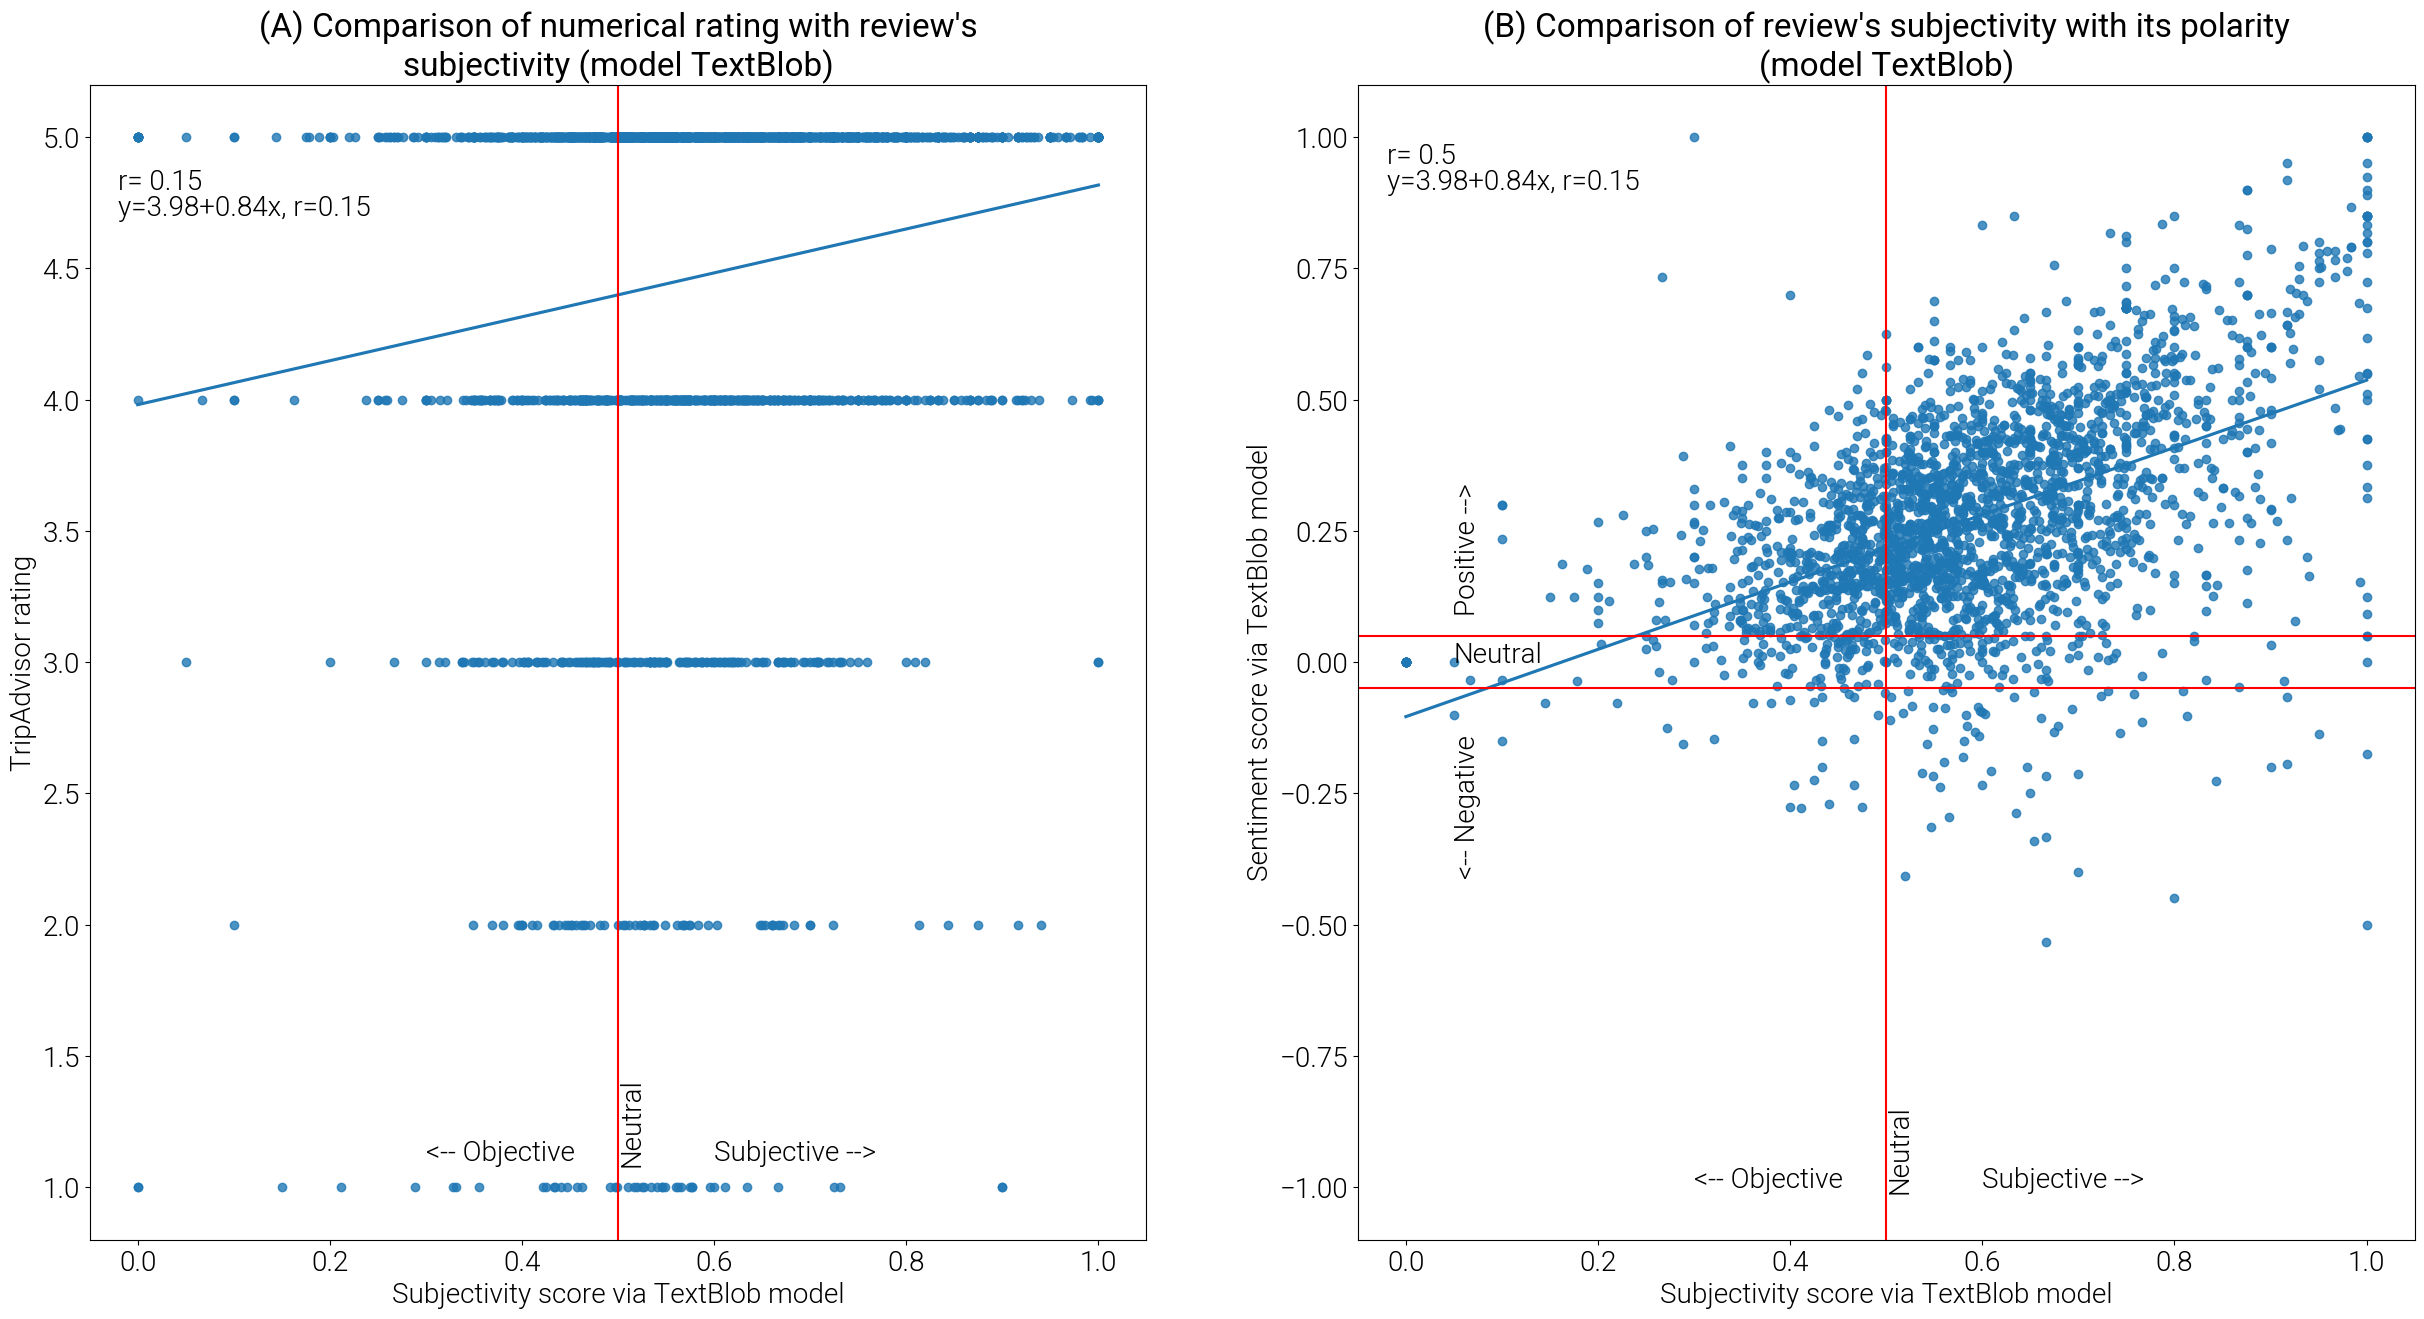

In [170]:
fig = plt.figure(figsize=(30, 15))
gs = GridSpec(1, 2, figure=fig)


ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])


g1 = sns.regplot(data=df_revs,  x='sent1_review_subjectivity', y='review_rating',  ci=None, ax=ax1)
ax1.axvline(0.5, label="Neutral", color='red')
ax1.annotate("Neutral", xy=(0.5,1.1), rotation=90)
ax1.annotate("Subjective -->", xy=(0.6,1.1))
ax1.annotate("<-- Objective", xy=(0.3,1.1))
ax1.annotate("Horrible", xy=(-1,1))
ax1.annotate("Weak", xy=(-1,2))
ax1.annotate("Average", xy=(-1,3))
ax1.annotate("Very good", xy=(-1,4))
ax1.annotate("Excelent", xy=(-1,5))
ax1.set(xlabel="\n".join(textwrap.wrap('Subjectivity score via TextBlob model',60)), ylabel='TripAdvisor rating')
ax1.set(title="\n".join(textwrap.wrap("(A) Comparison of numerical rating with review's subjectivity (model TextBlob)",60)))



g2 = sns.regplot(data=df_revs,  x='sent1_review_subjectivity', y='sent1_review_polarity',  ci=None, ax=ax2)
g2.set_ylim([-1.1,1.1])
ax2.axvline(0.5, label="Neutral", color='red')
ax2.annotate("Neutral", xy=(0.5,-1), rotation=90)
ax2.annotate("Subjective -->", xy=(0.6,-1))
ax2.annotate("<-- Objective", xy=(0.3,-1))
ax2.axhline(0.05, label="Neutral", color='red')
ax2.axhline(-0.05, label="Neutral", color='red')
ax2.annotate("Positive -->", xy=(0.05,0.1), rotation=90)
ax2.annotate("<-- Negative", xy=(0.05,-0.4), rotation=90)
ax2.annotate("Neutral", xy=(0.05, 0.0))
ax2.set(xlabel="\n".join(textwrap.wrap('Subjectivity score via TextBlob model',60)), ylabel='Sentiment score via TextBlob model')
ax2.set(title="\n".join(textwrap.wrap("(B) Comparison of review's subjectivity with its polarity (model TextBlob)",60)))



g1_prsn_cr = scipy.stats.pearsonr(df_revs['sent1_review_subjectivity'],df_revs['review_rating'])[0]
g1slope, g1intercept, g1r, g1p, g1stderr = scipy.stats.linregress(df_revs['sent1_review_subjectivity'],df_revs['review_rating'])
g1_reg_l = f'y={g1intercept:.2f}+{g1slope:.2f}x, r={g1r:.2f}'

g2_prsn_cr = scipy.stats.pearsonr(df_revs['sent1_review_subjectivity'], df_revs['sent1_review_polarity'])[0]
g2slope, g2intercept, g2r, g2p, g2stderr = scipy.stats.linregress(df_revs['sent1_review_subjectivity'],df_revs['sent1_review_polarity'])
g2_reg_l = f'y={g2intercept:.2f}+{g2slope:.2f}x, r={g2r:.2f}'


ax1.annotate("r= " + str(round(g1_prsn_cr,2)), xy=(-0.02,4.8))
ax2.annotate("r= " + str(round(g2_prsn_cr,2)), xy=(-0.02,0.95))
ax1.annotate(g1_reg_l, xy=(-0.02,4.7))
ax2.annotate(g1_reg_l, xy=(-0.02,0.9))

plt.savefig("dumps/exported_figs/subjectivity_scatter.svg", bbox_inches="tight")
